In [3]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv("../data/train.csv")
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Data Cleaning

In [4]:
# Check for missing values
missing_values = data.isnull().sum()
print(missing_values)

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


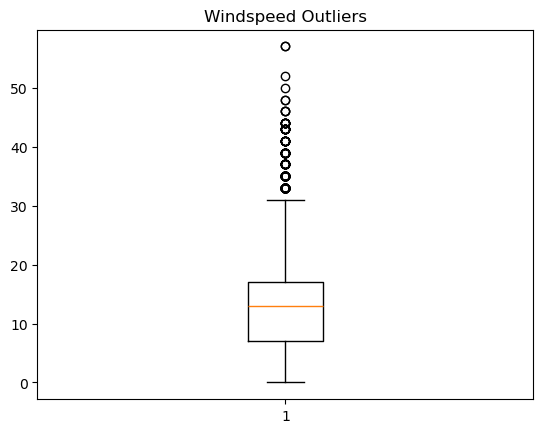

In [5]:
# Box plot to detect outliers in windspeed
plt.boxplot(data['windspeed'])
plt.title('Windspeed Outliers')
plt.show()
# Cap windspeed at a maximum threshold if necessary
data['windspeed'] = data['windspeed'].clip(upper=40)

In [6]:
# Remove rows with negative or erroneous values
data = data[data['temp'] >= 0]

## Feature Engineering

In [8]:
# Convert 'datetime' column to datetime object
data['datetime'] = pd.to_datetime(data['datetime'])

# Create new features
data['hour'] = data['datetime'].dt.hour
data['day_of_week'] = data['datetime'].dt.dayofweek
data['month'] = data['datetime'].dt.month

In [9]:
# Create binary weather features
data['is_clear_weather'] = (data['weather'] == 1).astype(int)
data['is_rainy_weather'] = (data['weather'] >= 3).astype(int)

In [10]:
# Create a combined feature for holidays and working days
data['is_holiday_workingday'] = ((data['holiday'] == 1) & (data['workingday'] == 1)).astype(int)

In [11]:
data.drop(columns=["datetime"], inplace=True)

## Data Split

In [12]:
from sklearn.model_selection import train_test_split
# Split the data into features and target
X = data.drop(columns=["count"])  # Features (all columns except 'count')
y = data["count"]  # Target variable
# Perform an 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Verify the split
print(f"Training data size: {X_train.shape}")
print(f"Testing data size: {X_test.shape}")

Training data size: (8708, 16)
Testing data size: (2178, 16)


## Starting MLFlow run and Logging

In [15]:
import mlflow
import mlflow.sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

2025/05/15 13:11:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model training complete. MAE: 3.6803246669967646, RMSE: 7.088694908391736


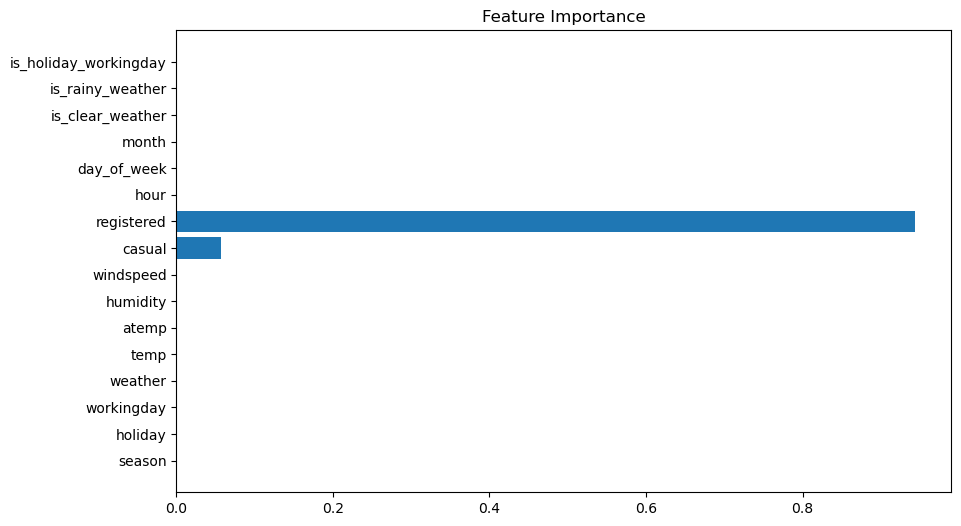

In [18]:
# Define the model 
model = DecisionTreeRegressor(max_depth=10, random_state=42)

# Start an MLflow run 
with mlflow.start_run():
    # Log model parameters
    mlflow.log_param("model_type", "DecisionTreeRegressor")
    mlflow.log_param("max_depth", 10)
    #Train the Model 
    model.fit(X_train, y_train)
    #Make predicition
    predictions = model.predict(X_test)
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    #Log evaluation metrics 
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("RMSE", rmse)
    # Plot and log feature importance as an artifact
    feature_importances = model.feature_importances_
    plt.figure(figsize=(10, 6))
    plt.barh(X_train.columns, feature_importances)
    plt.title("Feature Importance")
    plt.savefig("feature_importance.png")
    #Log artifacts(the feature importance plot)
    mlflow.log_artifact("feature_importance.png")
    #Log the model itself 
    mlflow.sklearn.log_model(model,"model")

print(f"Model training complete. MAE: {mae}, RMSE: {rmse}")

In [19]:
print(mlflow.get_tracking_uri())

file:///Users/shreyavaghani/Desktop/Personal%20DS%20projects/Bike-share-Prediction/BikeSharingMLops/notebooks/mlruns


## HyperTune Parameters - Log all the parameters

In [27]:
from itertools import product
from sklearn.model_selection import GridSearchCV

model = DecisionTreeRegressor(random_state=42)
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 10, 20]
}

with mlflow.start_run(run_name= "GridSearch for Regressor"):
    # Set up the gridSearchCV
    gridSearch = GridSearchCV(estimator=model, param_grid=param_grid, cv=5,
                               scoring='neg_mean_squared_error', verbose=1, return_train_score=True)
    gridSearch.fit(X_train, y_train)

    for i,param in enumerate(gridSearch.cv_results_['params']):
        meanScore = -gridSearch.cv_results_['mean_test_score'][i]
        stdScore = gridSearch.cv_results_['std_test_score'][i]

        with mlflow.start_run(run_name=f"Params {i+1}", nested=True):
            mlflow.log_params(param)
            mlflow.log_metric("mean_cv_rmse", meanScore)
            mlflow.log_metric("sd_cv_rmse", stdScore)

    best_params = gridSearch.best_params_
    best_score = -gridSearch.best_score_

    mlflow.log_params(best_params)
    mlflow.log_metric("best_cv_rmse", best_score)

    best_model = gridSearch.best_estimator_
    mlflow.sklearn.log_model(best_model, "best_model")

    test_predictions = best_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    mlflow.log_metric("test_RMSE", test_rmse)

print(f"Best Hyperparameters: {best_params}")
print(f"Test RMSE: {test_rmse}")


Fitting 5 folds for each of 9 candidates, totalling 45 fits


2025/05/15 14:20:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best Hyperparameters: {'max_depth': 15, 'min_samples_split': 10}
Test RMSE: 6.645717111734768
